<a href="https://colab.research.google.com/github/vasyl-d/vasyl-d/blob/main/Orders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

01.03.2023 10.03.2023


,id,created,status,client,ad,brand,total
0,T6442,1.3.2023,Закрито видано Клієнту,Юлия,Интернет,Hewlett-packard,3840.0
1,S4805401,1.3.2023,Закрито видано Клієнту,Олександр,Интернет,Lenovo,790.0
2,S4805501,1.3.2023,Закрито видано Клієнту,Ярослав,Интернет,Dell,1200.0
3,S4805601,1.3.2023,Закрито видано Клієнту,Ксенія,Интернет,Asus,1200.0
4,S4805701,1.3.2023,Закрито видано Клієнту,Сахно Жанна,Интернет,Lenovo,1600.0
5,S4805801,1.3.2023,Закрито видано Клієнту,Коноваленко Михайло Валерійович,Живу поруч,Asus,2390.0
6,S4806101,1.3.2023,Закрито видано Клієнту,Іван,Интернет,Lenovo,800.0
7,S4806901,1.3.2023,Закрито видано Клієнту,Володимир,Интернет,clevo,990.0
8,S4807301,1.3.2023,🏆Готово. В обробці.,Товариство з обмеженою відповідальністю «Рейка...,Интернет,Asus,3000.0
9,T6463,1.3.2023,🏆 Готово,"ТОВ ""СМАРТІВЕЙ ЮКРЕЙН""",Интернет,Acer,1490.0


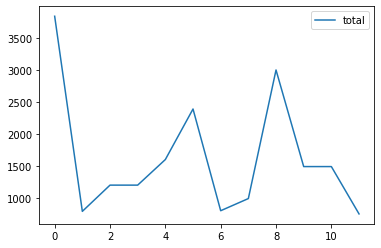

In [34]:
from numpy import true_divide
#@title Строим отчет по типу устройства в заказе

assetType = "\u041D\u043E\u0443\u0442\u0431\u0443\u043A" #@param {type:"string"}
apiKey = "f0b3e83a73964060b1cfc68c43802e42" #@param {type: "string"}
dateFrom = "01.03.2023" #@param {type:"date"}
dateTo = "10.03.2023" #@param {type:"date"}

import requests
import pandas as pd
import time
import matplotlib.pyplot as plt

class DictObj:
    '''класс для преобразования json в обьект'''
    def __init__(self, in_dict:dict):
       	if isinstance(in_dict, dict):
            for key, val in in_dict.items():
                if isinstance(val, (list, tuple)):
                    setattr(self, key, [DictObj(x) if isinstance(x, dict) else x for x in val])
                else:
                    setattr(self, key, DictObj(val) if isinstance(val, dict) else val)
        else:
            assert False, 'must be dict in parm'

print(dateFrom, dateTo)
(d,m,y) = map(int, dateFrom.split('.'))
dayFromInt = round(time.mktime((y,m,d, 0,0,0,0,0,0)))*1000

(d,m,y) = map(int, dateTo.split('.'))
dayToInt = round(time.mktime((y,m,d, 0,0,0,0,0,0)))*1000

def getToken(apiKey):
  url = 'https://api.remonline.app/token/new'
  token = None
  payload={'api_key': apiKey}
  files=[

  ]
  headers = {}
  try:
      response = requests.request("POST", url, headers=headers, data=payload, files=files)
      response.raise_for_status()
      data = response.json()
      token = data["token"]
  except Exception as error:
      print(error)
  return token

def getOrders(token):
  url = f'https://api.remonline.app/order/?token={token}&created_at[]={dayFromInt}&created_at[]={dayToInt}'
  payload={}
  files=[

  ]
  headers = {}
  retData = []
  try:
    response = requests.request("GET", url, headers=headers, data=payload, files=files)
    response.raise_for_status()
    data = response.json()
    retData = data.get("data",[])
  except Exception as error:
      print(error)
  return retData

def mkDate(tm):
  y, m, d, *rest = time.localtime(tm/1000)
  return f"{d}.{m}.{y}"

def getProductsPrice(pr):
  return round(sum(el.get('price') *el.get('amount') - el.get('discount_value') for el in pr), 2)


token = getToken(apiKey)
orders = getOrders(token)

res = [(el.get('id_label'), mkDate(el.get('created_at')),el.get('status').get('name'), 
        el.get('client').get('name'),el.get('ad_campaign').get('name'), el.get('asset').get('brand'),
        getProductsPrice(el.get('parts'))+getProductsPrice(el.get('operations'))) for el in orders if el.get('asset').get('group') == assetType]

res1 = pd.DataFrame(res, columns = ["id", "created", "status", "client", "ad", "brand", "total"])
res1.plot();

from google.colab import data_table
data_table.DataTable(res1, include_index=True, num_rows_per_page=10)

